# Bibs used

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

## Import data

In [2]:
nome_estado = 'Rio de Janeiro' # name of state
estado = 'RJ' # acronym
capital = 'Rio de Janeiro' # capital
pop_capital = {'SC': 7165000,'CE': 8843000, 'SE':664908,'ES':365855,'BA': 2900319,'RJ':6.748*10**6,'SP':12.33*10**6,'MG':2.722*10**6}
M = pd.read_csv('Connections '+ estado +'.csv',index_col =0) # connection information 
M.fillna(0,inplace=True)                                           # individuals from the city in the row go to the city in the column
                                                                   # diagonally you will find the city's population
M.loc["total flow to capital"]=M.loc["total flow to capital"].astype(int)
M.loc["higher flow to a city in-out"]=M.loc["higher flow to a city in-out"].astype(int)
M.loc["higher flow to a city out-in"]=M.loc["higher flow to a city out-in"].astype(int)


casos = pd.read_csv('Notifications '+estado+'.csv',index_col = 0)      # reading the accumulated cases and converting to numpy type

### Transform notification

In [3]:
infectados = np.zeros(casos.index.size) # memory to actives infections 
N = pop_capital[estado]
u = 1/8 # recovery rate
infectados[0]=casos[capital].iloc[0] # notifications cases per day
for k in range(1,casos.index.size):
    infectados[k]=(1-u)*infectados[k-1]+casos[capital].iloc[k] 
    

## Code to find the initial growth curve of infections 

array([-9.62113952,  0.041923  ])

6.631201043373441e-05

2.3984772806761177

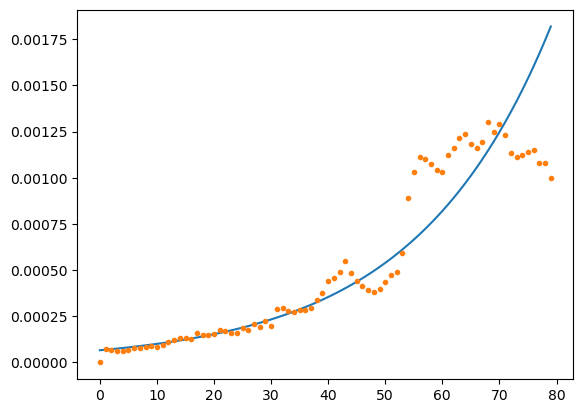

In [4]:
de = 1 
ate = 80
fig,ax=plt.subplots()
y = np.log(infectados[de:ate]/N) # to linearly adjust the range from 0 to 80 days
tempo = np.arange(de,ate) # input time
Ma = np.array([np.ones(tempo.shape),tempo]) # matrix input
c_tau = np.linalg.inv(Ma@Ma.T)@Ma@y.T # pseudo inverse

#ate=150
tempo = np.arange(0,ate) # input time
ax.plot(tempo,np.exp(c_tau[1]*tempo+c_tau[0])) # fitted curve
ax.plot(tempo,infectados[0:ate]/N,'.') # data


ultimo = -c_tau[0]/c_tau[1] # superior limit of the last day of infection
display(c_tau)
display(np.exp(c_tau[0])) # i[0]
display(np.exp(8*c_tau[1])+1) # R_0

## Distribution

In [5]:
# entradas: c_tau e M, probabilidade de selecionar um não infectado = (1-exp(c_tau[1]*t+c_tau[0]))
def distr(c_tau,M): 
    ultimo = -c_tau[0]/c_tau[1] # the city will be infected till this day
    t = np.arange(0,ultimo) # memory time
    p_t = (1-np.exp(c_tau[1]*t+c_tau[0]))**M # probability of selections M's not infected individuals
    np.append(p_t,1)
    p_dia = np.zeros(p_t.shape)
    aux=1
    for k in range(0,p_t.size):
        p_dia[k]=aux*(1-p_t[k])
        aux = aux*p_t[k]

    return p_dia

### Helps building the graphics

In [6]:
def quant(vetor,p):
    if sum(vetor)==0:
        return 0,0
    sv = np.zeros(vetor.size)
    sv[0]=vetor[0]
    for k in np.arange(1,vetor.size):
        sv[k]=sv[k-1]+vetor[k]
    aux = np.where(sv>=p)
    inf=aux[0][0]
    aux = np.where(sv>1-p)
    sup=aux[0][0]
    return inf+1,sup+1

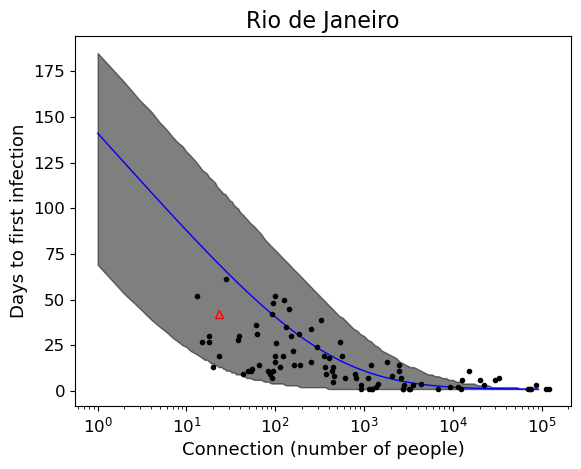

In [7]:
ate = 125
count = 0 # counter for all cities and are within the 95% limits
countdz = 0 # counter for all cities
countcon = 0 # counter for the cities that have the greatest connection with their capital state are within the 95% limits
countcont=0 # counter for the cities that have the greatest connection with their capital state
cmce=[] # cities that don't have greatet connection with their capital state
################## plot theoretical limits for range of connections ###########
Mc = np.zeros(ate)
Mc[0:40] = np.arange(1,41) # linear scale
Mc[40:] = (10**(np.arange(40,ate)/25)).round() # log scale
dias = np.zeros(ate)
inf = np.zeros(ate)
sup = np.zeros(ate)
dias_reais = np.zeros(casos.columns.size)
ultimo = -c_tau[0]/c_tau[1] # the city will be infected till that day
t = np.arange(1,ultimo+1) # days memory
figc, axc = plt.subplots()
cidades = casos.columns
######################## theoretical limits ##############
for k in range(0,ate):
    pdias = distr(c_tau,Mc[k])
    dias[k]=(t*pdias).sum() 
    inf[k],sup[k]=quant(pdias,0.025)
  
axc.plot(Mc,dias,'b',linewidth=1.0)
axc.fill_between(Mc,inf,sup, alpha=0.5,color='black')
##########################################################

###############################################################################
dias_reais = {}
for k in casos.columns:
    dias_reais[k] =np.where(casos[k].to_numpy()>0)[0][0] # day of first infected notification 

############## real data plots ######################################
for k in M.columns:
    cidaux = dias_reais[M[k]['name']] # day of first infection 
    aux = M[k]["total flow to capital"] # connection of people
    pdias = distr(c_tau,aux) # theoretical distribution 
    inft,supt=quant(pdias,0.025) # limits of 95% 
    if (aux>(M[k]['higher flow to a city out-in']+M[k]['higher flow to a city in-out'])): # if high connection of city is with her capital
        
        axc.plot(aux,cidaux,'.k') 
        if (cidaux>=inft)&(cidaux<=supt): # if in 95%, count
            countcon=countcon+1  
       
        countcont=countcont+1 # if high connection of city is with her capital, count
    else: # if high connection of city isn't with her capital
        axc.plot(aux,cidaux,'r^',  fillstyle='none')
        cmce.append(M[k]['name']) # cities in red
    #axc.text(M[cidades[k].upper()]["total"],dias_reais[k],cidades[k])
    
    if M[k]["total flow to capital"]>0: 
        countdz=countdz+1 # count of city with some connection with her capital
        if (cidaux>=inft)&(cidaux<=supt): 
            count=count+1  # count if sample is in the 95%
####################################################################


axc.tick_params(axis='both', which='major', labelsize=12)
axc.set_xscale('log')
axc.set_xlabel('Connection (number of people)',fontsize=13)

axc.set_ylabel('Days to first infection',fontsize=13)

axc.set_title(nome_estado,fontsize=16)
plt.savefig(nome_estado+'.png',format='png',dpi=1000)
plt.show()


In [8]:
M.columns.size # number of cities in state

92

In [9]:
casos.columns.size - sum(M.loc["total flow to capital"]==0) # number of cities with connections

91

In [10]:
sum(M.loc["total flow to capital"]==0) # number of cities with no connections with her capital, it was not used 

1

In [11]:
count/(countdz) # fraction of total cities in 95%


0.9230769230769231

In [12]:
countcon/countcont # fraction of cities that have higher connection with her capital in 95%

0.9222222222222223

In [13]:
countdz  # number of cities with connections

91

In [14]:
count

84

In [15]:
for k in M.columns:
    if M[k]['total flow to capital']==0:
        print (M[k]['name']) # cities with no connections to her capital by ibge

Rio de Janeiro


In [16]:
cmce # cities that don't have greatet connection with their capital state

['Cardoso Moreira', 'Rio de Janeiro']